# Evolutionäre Hyperparameteroptimierung

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.datasets import make_blobs

## Datengrundlage

In [20]:
class Distribution:
    def __init__(self,n_components=5):
        X, truth = make_blobs(n_samples=500, centers=n_components, cluster_std = [np.random.uniform()*3 for i in range(n_components)],random_state=41)
        self.x = X[:, 0]
        self.y = X[:, 1]
        self.xx, self.yy = np.mgrid[np.min(self.x):np.max(self.x):500j, np.min(self.y):np.max(self.y):500j]
        self.kernel = st.gaussian_kde(np.vstack([self.x, self.y]))
        self.distribution = 1-((np.reshape(self.kernel(np.vstack([self.xx.ravel(), self.yy.ravel()])).T, self.xx.shape)+np.linspace(-0.005,0.002,500).reshape(500,1))**2)
        self.norm_distribution = (self.distribution-np.min(self.distribution))/(np.max(self.distribution)-np.min(self.distribution))
    
    def predict(self,x,y):
        closest_x = np.argmin(np.absolute(np.linspace(np.min(self.x),np.max(self.x),500)-x))
        closest_y = np.argmin(np.absolute(np.linspace(np.min(self.y),np.max(self.y),500)-y))
        return self.norm_distribution[closest_x,closest_y]
        

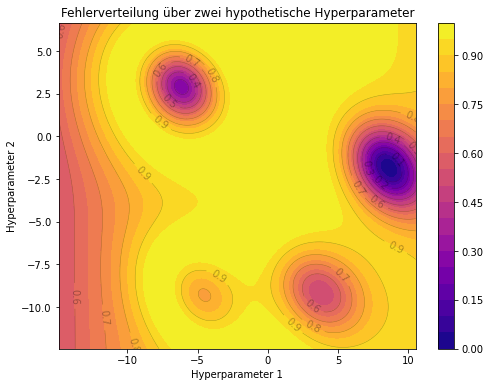

In [21]:
dis = Distribution()
plt.figure(figsize=(8,6))
plt.xlim(np.min(dis.x), np.max(dis.x))
plt.ylim(np.min(dis.y), np.max(dis.y))
cset = plt.contour(dis.xx, dis.yy, dis.norm_distribution,colors="k",levels=10,alpha=0.3,linewidths=0.5)
plt.contourf(dis.xx, dis.yy, dis.norm_distribution,levels=20,cmap="plasma")
plt.colorbar()
plt.clabel(cset, inline=1, fontsize=10)
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title('Fehlerverteilung über zwei hypothetische Hyperparameter')
plt.show()

## Evolutionäre Optimierung

In [33]:
population_size = 20
survival_rate = 0.25
survivals = int(population_size*survival_rate)

# Population initialisieren
population_x = np.random.uniform(np.min(dis.x), np.max(dis.x),population_size)
population_y = np.random.uniform(np.min(dis.y), np.max(dis.y),population_size)

# Gesamte Population tracken für Visualisierung
overall_population_x = [i for i in population_x]
overall_population_y = [i for i in population_y]
    
fittest_gene = False
best_fittnes = np.inf

In [34]:
for generation in range(10):
    # Fitness messen
    performances = np.array([dis.predict(xi,yi) for xi,yi in zip(population_x,population_y)])
    fittest_population_x = population_x[performances.argsort()[:survivals]]
    fittest_population_y = population_y[performances.argsort()[:survivals]]
    
    # Beste Fitness speichern
    if np.min(performances) < best_fittnes:
        best_fittnes = np.min(performances)
        fittest_gene = [population_x[np.argmin(performances)],population_y[np.argmin(performances)]]
        
    # Population neu "gebären"
    new_x = []
    new_y = []
    for i in range(population_size-survivals):
        random_weight = np.random.uniform(0,1)
        parents = np.random.choice(range(survivals),size=2, replace=False)
        
        new_x.append(fittest_population_x[parents[0]]*random_weight+fittest_population_x[parents[1]]*(1-random_weight))
        new_y.append(fittest_population_y[parents[0]]*random_weight+fittest_population_y[parents[1]]*(1-random_weight))
        
    overall_population_x = overall_population_x+[i for i in new_x]
    overall_population_y = overall_population_y+[i for i in new_y]

    # Neue Population
    population_x = np.array(list(fittest_population_x) + new_x)
    population_y = np.array(list(fittest_population_y) + new_y)


Bester Punkt mit z=0.00 gefunden bei [8.650483265268981, -1.8415939075179715]


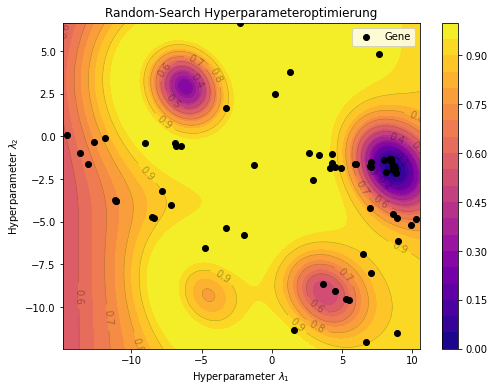

In [26]:
print("Bester Punkt mit z={:.2f} gefunden bei {}".format(best_fittnes, fittest_gene))        

plt.figure(figsize=(8,6))
plt.xlim(np.min(dis.x), np.max(dis.x))
plt.ylim(np.min(dis.y), np.max(dis.y))
cset = plt.contour(dis.xx, dis.yy, dis.norm_distribution,colors="k",levels=10,alpha=0.3,linewidths=0.5)
plt.contourf(dis.xx, dis.yy, dis.norm_distribution,levels=20,cmap="plasma")
plt.colorbar()

plt.scatter(overall_population_x, overall_population_y, c="black",label="Gene")
#plt.scatter(fittest_population_x, fittest_population_y, c="green",label="Fitteste")

plt.clabel(cset, inline=1, fontsize=10)
plt.xlabel('Hyperparameter $\lambda_1$')
plt.ylabel('Hyperparameter $\lambda_2$')
plt.title('Random-Search Hyperparameteroptimierung')
plt.legend(loc='upper right')
plt.show()